# Galīgo automātu lietojums morfoloģiskajā apstrādē | Finite state automata for morphology processing

Helsinki Finite State Transdusers (HFST)
Skat. arī.: https://github.com/hfst/compmorph-course/tree/v1.0

In [2]:
!pip install hfst

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 11.2 MB/s eta 0:00:00


In [3]:
!pip install hfst_dev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 MB 8.1 MB/s eta 0:00:00


In [4]:
import hfst as hfst

In [6]:
help(hfst)

Help on package hfst:

NAME
    hfst - Python bindings for HFST finite-state transducer library written in C++.

DESCRIPTION
    FUNCTIONS:
    
        compile_lexc_file
        compile_pmatch_expression
        compile_pmatch_file
        compile_xfst_file
        concatenate
        disjunct
        empty_fst
        epsilon_fst
        fsa
        fst
        fst_type_to_string
        get_default_fst_type
        get_output_to_console
        intersect
        is_diacritic
        read_att_input
        read_att_string
        read_att_transducer
        read_prolog_transducer
        regex
        set_default_fst_type
        set_output_to_console
        start_xfst
        tokenized_fst
    
    CLASSES:
    
        AttReader
        HfstBasicTransducer
        HfstBasicTransition
        HfstInputStream
        HfstOutputStream
        HfstTokenizer
        HfstTransducer
        ImplementationType
        LexcCompiler
        PmatchContainer
        PrologReader
        XfstC

In [5]:
help(hfst.compile_lexc_file)

Help on function compile_lexc_file in module hfst:

compile_lexc_file(filename, **kwargs)
    Compile lexc file *filename* into a transducer.
    
    Parameters
    ----------
    * `filename` :
        The name of the lexc file.
    * `kwargs` :
        Arguments recognized are: verbosity, with_flags, output.
    * `verbosity` :
        The verbosity of the compiler, defaults to 0 (silent). Possible values are:
        0, 1, 2.
    * `with_flags` :
        Whether lexc flags are used when compiling, defaults to False.
    * `output` :
        Where output is printed. Possible values are sys.stdout, sys.stderr, a
        StringIO, sys.stderr being the default.
    
    Returns
    -------
    On success the resulting transducer, else None.



In [ ]:
help(hfst.compile_twolc_file)

## Vārdformu ģenerators | Word form synthesis





### LV: Leksikons kodā | EN: Small lexicon in code

In [7]:
import hfst_dev
from hfst_dev import compile_lexc_script

In [11]:
gen = compile_lexc_script(
"""
Multichar_Symbols
        +N      ! Noun tag
        +Sg     ! Singular
        +Pl     ! Plural
        +Nom
        +Gen
        +Dat
        +Acc
        +Loc

LEXICON Root
        Nouns ; ! No input, no output

!
! NOUNS start here
!

LEXICON Nouns

rok N4dekl;



LEXICON N4dekl
+N+Sg+Nom:^a  #;
+N+Sg+Gen:^as #;
+N+Sg+Dat:^ai #;
+N+Sg+Acc:^u #;
+N+Sg+Loc:^ā #;
+N+Pl+Nom:^as  #;
+N+Pl+Gen:^u  #;
+N+Pl+Dat:^ām #;
+N+Pl+Acc:^as #;
+N+Pl+Loc:^ās #;


END
""", verbosity=2
)


Root...1 Nouns...1 N4dekl...Morphotaxing... # Morphotaxing... N4dekl Morphotaxing... Nouns Morphotaxing... Root 
Inserting regular expressions...



In [12]:
print(gen.lookup('rok+N+Sg+Dat'))

(('rok^ai', 0.0),)


### LV: Leksikons atsevišķā failā | EN: Lexicon in separate file

In [1]:
import hfst
generator = hfst.compile_lexc_file('lvLex.lexc')
print(generator.lookup('rok+N+Sg+Gen'))

(('rok^as', 0.0),)


## Transdjūseri: divu līmeņu morfoloģija | Transducers: two level morphology


### LV: Morfoloģiskā analīze | EN: Morphologycal analysis

In [3]:
from hfst import HfstTransducer
analyzer = HfstTransducer(generator) # create a copy
print(analyzer.lookup('rok+N+Sg+Nom'))


(('rok^a@_EPSILON_SYMBOL_@', 0.0),)


In [4]:
analyzer.invert()
analyzer.minimize()
print(analyzer.lookup('plān^s'))

()


In [5]:
# salīdzināšana | comparison
analyzer.invert()
analyzer.minimize()
print(analyzer.compare(generator))

True


## FST kaskādēšana | **Cascading**

Pārveidošanas likumi
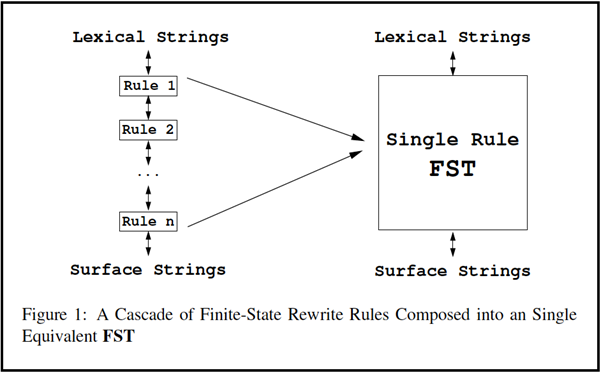

In [6]:
from hfst import regex, HfstTransducer

Iespraušana

In [8]:
#Insertion
InsertJ = hfst.regex('[..] -> j || [b | f | m | p | v] _ "^" M')
print(InsertJ.lookup("ķirb^Ma'"))

(("ķirbj^Ma'", 0.0),)


Aizstāšana

In [9]:
# Replacement
CReplacement = hfst.regex('c -> č ||  _ "^" M')
print(CReplacement.lookup("lāc^Ma'"))






(("lāč^Ma'", 0.0),)


Izņēmumi

In [11]:
#Exceptions
Exceptions = hfst.regex('[[{puik} "+N" "+Sg" "+Dat" .x. {puikam}] ]')


Dzēšana

In [12]:
#Deleting
MCleanup = hfst.regex('M -> 0')
Cleanup = hfst.regex('"^" -> 0')

## FST apvienošana | Copmpsition

In [14]:
tr = hfst.HfstTransducer(generator)
#generator.remove_epsilons()
from hfst import compose
cascade = compose((generator, InsertJ, CReplacement, MCleanup,Cleanup))


In [16]:
#cascade.remove_epsilons()
#print(cascade.lookup("peļķ+N+Pl+Loc"))
print(cascade.lookup("rok+N+Pl+Loc")[0][0].replace("@_EPSILON_SYMBOL_@", ""))





rokās


In [20]:
inv = hfst.HfstTransducer(cascade)
inv.invert()
inv.convert(hfst.ImplementationType.HFST_OL_TYPE)

In [21]:
print(inv.lookup("ķirbja"))

(('ķirb+N+Sg+Gen', 0.0),)
